# Modelo definitivo Educación Continua

## Tabla de contenidos
    1. Carga librerías y base de datos
    2. Manejo de bases de datos
    3. Construcción modelo definitivo
    4. Plan piloto

## Carga librerías y base de datos

In [1]:
%pip install pytrends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytrends: filename=pytrends-4.8.0-py3-none-any.whl size=16127 sha256=65336587f273f089e062b7a315f92f678f36f43cee8bbc35e5b323bd0d981b65
  Stored in directory: /root/.cache/pip/wheels/e8/78/c8/18d4f4804753e14416809b365773220c48b41fe5387f2bb6b9
Successfully built pytrends


In [2]:
%pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.0 MB/s 


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import datetime as dt
import unidecode
from pytrends.request import TrendReq
import math
from datetime import datetime
# from flask import request
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
# import statsmodels.api as sm

plt.style.use('ggplot')

# /mnt/analiticastorage_educacion-continua
# Cambiar directorio de trabajo #
# os.chdir('/Users/JUANGARCESC/Documents/OneDrive - Universidad de Los Andes/2021/008-21 Modelo EDCO/Bases')

# Cargar base de datos con direcciones #
base=pd.read_csv('/content/ConsultaGT.csv')

base=base.drop_duplicates(['Consecutivo.del.curso']).reset_index()

# Transformaciones a variables de la base
base['Valor.por.hora']=pd.to_numeric(base['Valor.por.hora'].str.replace('[^\w\s]', ''))
base['Curso.nuevo'] = base['Curso.nuevo'].replace({'Sí':1, 'No':0})

# Dimensiones de la base de datos
base.shape

<ipython-input-3-c213cfa9c126>:39: FutureWarning: The default value of regex will change from True to False in a future version.
  base['Valor.por.hora']=pd.to_numeric(base['Valor.por.hora'].str.replace('[^\w\s]', ''))


(1310, 82)

## Manejo de bases de datos

In [4]:
# Variables continuas:
feature_cols = ['maDesemp', 'maIPC', 'maTasaInt', 'maTRM', 'maGT_EduCon', 'maGT_Coursera', 'maGT_Cursos', 
                'maGT_Cert', 'maGT_platzi', 'maGT_udemy', 'trafico', 'clics', 'CTR', 'CPC', 'campanias', 
                'Envios', 'Aperturas', 'Clics', 'TasaApertura', 'TasaClicEn', 'TasaClicAp', 'NumCursos',
                'NumCursosFac', 'Keywords', 'Valor.por.hora']

# Variables categóricas:
feature_cat=['Exitoso2', 'Facultad', 'Modalidad', 'Categoría', 'Curso.nuevo', 'Programa']

# Establecer la base con variables a incluir
X = base[feature_cols+feature_cat]

# Eliminar valores vacíos en variables de marketing 
X=X[X['trafico'].notna()]

## Imputar info a variables con NA
# Variables a reemplazar con 0
var0=['CTR','CPC','campanias', 'Envios', 'Aperturas', 'Clics', 'TasaApertura','Keywords']
X[var0] = X[var0].replace({np.nan:0})

# Variables a imputar con media
varM=['Valor.por.hora']
X[varM]=X[varM].fillna(X[varM].mean())

# Dummies de variables categoricas
Categoria_dummies = pd.get_dummies(X.Categoría, prefix='Cat')
Categoria_dummies.drop(Categoria_dummies.columns[0], axis=1, inplace=True)

Modalidad_dummies = pd.get_dummies(X.Modalidad, prefix='Mod')
Modalidad_dummies.drop(Modalidad_dummies.columns[0], axis=1, inplace=True)

Facultad_dummies = pd.get_dummies(X.Facultad, prefix='Fac')
Facultad_dummies.drop(Facultad_dummies.columns[0], axis=1, inplace=True)


#X = pd.concat([X.drop(columns=['Facultad', 'Modalidad', 'Categoría']), Categoria_dummies, Modalidad_dummies, Facultad_dummies], axis=1)




In [5]:
#X = X.withColumn('Keywords', F.regexp_replace(F.col('Keywords'), ',', '.').cast('float'))

In [6]:
X[['Curso.nuevo',	'Programa',	'NumCursos',	'NumCursosFac',	'Keywords',	'Valor.por.hora',	'Categoría',	'Modalidad',	'Facultad'	,'Exitoso2',	'Keywords']]

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Exitoso2,Keywords
0,0,1,6,1,6.238095,45000.000000,Actualización Profesional,Presencial,ECONOMIA,0,6.238095
1,1,1,6,4,6.977778,0.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0,6.977778
2,1,1,6,4,7.571429,0.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0,7.571429
3,1,1,6,1,12.566667,64951.430837,Niños y Jóvenes,Presencial,ARTES Y HUMANIDADES,1,12.566667
4,0,1,6,4,6.977778,37500.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0,6.977778
...,...,...,...,...,...,...,...,...,...,...,...
1303,0,0,43,9,26.714286,61500.000000,Actualización Profesional,Virtual,CIENCIAS SOCIALES,0,26.714286
1304,0,0,43,4,50.285714,71281.000000,Actualización Profesional,Virtual,DERECHO,0,50.285714
1305,0,0,43,9,18.375000,81333.000000,Actualización Profesional,Virtual,INGENIERIA,0,18.375000
1306,0,0,43,9,19.071429,63233.000000,Actualización Profesional,Virtual,CIENCIAS SOCIALES,1,19.071429


In [7]:
X['Keywords'] = X.Keywords.astype(float)

In [8]:
X['Keywords'].map('${:,.2f}'.format)

0        $6.24
1        $6.98
2        $7.57
3       $12.57
4        $6.98
         ...  
1303    $26.71
1304    $50.29
1305    $18.38
1306    $19.07
1307     $8.38
Name: Keywords, Length: 1308, dtype: object

In [9]:
X3 =X[['Curso.nuevo',	'Programa',	'NumCursos',	'NumCursosFac',	'Keywords',	'Valor.por.hora',	'Categoría',	'Modalidad',	'Facultad'	,'Exitoso2']]

In [10]:
X3['Keywords'] =X3['Keywords'].map('{:,.2f}'.format)

<ipython-input-10-00d27a68f645>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['Keywords'] =X3['Keywords'].map('{:,.2f}'.format)


In [11]:
X3['Valor.por.hora'] =X3['Valor.por.hora'].map('{:,.2f}'.format)

<ipython-input-11-71f4120b61bd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X3['Valor.por.hora'] =X3['Valor.por.hora'].map('{:,.2f}'.format)


In [12]:
X3

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Exitoso2
0,0,1,6,1,6.24,"45,000.00",Actualización Profesional,Presencial,ECONOMIA,0
1,1,1,6,4,6.98,0.00,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0
2,1,1,6,4,7.57,0.00,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0
3,1,1,6,1,12.57,"64,951.43",Niños y Jóvenes,Presencial,ARTES Y HUMANIDADES,1
4,0,1,6,4,6.98,"37,500.00",Bienestar - Desarrollo Personal,Presencial,INGENIERIA,0
...,...,...,...,...,...,...,...,...,...,...
1303,0,0,43,9,26.71,"61,500.00",Actualización Profesional,Virtual,CIENCIAS SOCIALES,0
1304,0,0,43,4,50.29,"71,281.00",Actualización Profesional,Virtual,DERECHO,0
1305,0,0,43,9,18.38,"81,333.00",Actualización Profesional,Virtual,INGENIERIA,0
1306,0,0,43,9,19.07,"63,233.00",Actualización Profesional,Virtual,CIENCIAS SOCIALES,1


In [13]:
X3.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1307
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Curso.nuevo     1308 non-null   int64 
 1   Programa        1308 non-null   int64 
 2   NumCursos       1308 non-null   int64 
 3   NumCursosFac    1308 non-null   int64 
 4   Keywords        1308 non-null   object
 5   Valor.por.hora  1308 non-null   object
 6   Categoría       1308 non-null   object
 7   Modalidad       1308 non-null   object
 8   Facultad        1308 non-null   object
 9   Exitoso2        1308 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 112.4+ KB


In [14]:
X3.to_csv('/content/Entrenamiento2.csv', sep=';', index=False)

In [15]:
# Eliminar filas completamente vacías
X=X.dropna()
features_col = ['Curso.nuevo', 'Programa', 'NumCursos', 'NumCursosFac', 'Keywords',
       'Valor.por.hora', 'Categoría', 'Modalidad', 'Facultad']
X_2 = X[features_col].copy()

y = X.Exitoso2
X = X.drop(columns=['Exitoso2'])

In [16]:
X_2

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad
0,0,1,6,1,6.238095,45000.000000,Actualización Profesional,Presencial,ECONOMIA
1,1,1,6,4,6.977778,0.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA
2,1,1,6,4,7.571429,0.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA
3,1,1,6,1,12.566667,64951.430837,Niños y Jóvenes,Presencial,ARTES Y HUMANIDADES
4,0,1,6,4,6.977778,37500.000000,Bienestar - Desarrollo Personal,Presencial,INGENIERIA
...,...,...,...,...,...,...,...,...,...
1303,0,0,43,9,26.714286,61500.000000,Actualización Profesional,Virtual,CIENCIAS SOCIALES
1304,0,0,43,4,50.285714,71281.000000,Actualización Profesional,Virtual,DERECHO
1305,0,0,43,9,18.375000,81333.000000,Actualización Profesional,Virtual,INGENIERIA
1306,0,0,43,9,19.071429,63233.000000,Actualización Profesional,Virtual,CIENCIAS SOCIALES


In [17]:
y

0       0
1       0
2       0
3       1
4       0
       ..
1303    0
1304    0
1305    0
1306    1
1307    0
Name: Exitoso2, Length: 1308, dtype: int64

In [18]:
# Dividir la base de datos en entrenamiento y prueba
random.seed(2022)
X_train, X_test, y_train, y_test = train_test_split(
            X_2, 
            y, 
            test_size=.3,
            random_state=2022)
print (X_train)

      Curso.nuevo  Programa  NumCursos  NumCursosFac   Keywords  \
354             1         1         38             9  13.178571   
462             1         1         40             5   0.000000   
1018            1         1         46             4  21.261905   
919             0         1         41             3  23.250000   
234             1         1         57             8  38.380952   
...           ...       ...        ...           ...        ...   
240             1         1         57             2  12.571429   
624             0         1         78             3   0.357143   
173             1         1         43             9  21.428571   
1244            0         1         39            10  27.333333   
893             1         1         29             3  40.857143   

      Valor.por.hora                        Categoría   Modalidad  \
354          70813.0        Actualización Profesional  Presencial   
462          55000.0        Actualización Profesional    

## Construcción modelo definitivo

In [19]:
#Transformacion OHE
ct = ColumnTransformer([('ohe', OneHotEncoder(handle_unknown = 'ignore'), ['Categoría', 'Modalidad', 'Facultad'])], remainder='passthrough')
ct 


ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(handle_unknown='ignore'),
                                 ['Categoría', 'Modalidad', 'Facultad'])])

In [20]:
# Clasificador
rfc = RandomForestClassifier(n_estimators=100, random_state = 2022)
rfc


RandomForestClassifier(random_state=2022)

In [21]:
# Construcción del pipeline
pipe = Pipeline([('ctransformer', ct), ('clf', rfc)])
pipe

Pipeline(steps=[('ctransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Categoría', 'Modalidad',
                                                   'Facultad'])])),
                ('clf', RandomForestClassifier(random_state=2022))])

In [22]:
pipe = pipe.fit(X_train,y_train)
pipe

Pipeline(steps=[('ctransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Categoría', 'Modalidad',
                                                   'Facultad'])])),
                ('clf', RandomForestClassifier(random_state=2022))])

In [23]:
pipe.score(X_test, y_test)

0.7582697201017812

In [24]:
X_test.columns

Index(['Curso.nuevo', 'Programa', 'NumCursos', 'NumCursosFac', 'Keywords',
       'Valor.por.hora', 'Categoría', 'Modalidad', 'Facultad'],
      dtype='object')

In [25]:
X_test

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad
1089,1,1,56,6,32.196429,56375.000000,"Arte, Ciencias y Humanidades",Virtual,ARTES Y HUMANIDADES
35,0,1,24,3,7.642857,62964.000000,Bienestar - Desarrollo Personal,Presencial,CIENCIAS SOCIALES
781,1,1,67,4,0.000000,65476.000000,Actualización Profesional,Virtual,ECONOMIA
684,1,1,66,15,38.690476,64951.430837,Lenguas,Presencial,CENTRO DE LENGUAS
949,1,1,41,2,57.142857,55000.000000,Actualización Profesional,Virtual,MEDICINA
...,...,...,...,...,...,...,...,...,...
888,1,1,29,3,38.500000,55000.000000,Actualización Profesional,Virtual,MEDICINA
1215,1,1,41,5,30.900000,72600.000000,Actualización Profesional,Virtual,DERECHO
1283,0,0,33,14,34.833333,23063.000000,Lenguas,Virtual,CIENCIAS SOCIALES
328,1,1,39,11,10.428571,125000.000000,Actualización Profesional,Presencial,INGENIERIA


In [ ]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       264
           1       0.68      0.50      0.58       129

    accuracy                           0.76       393
   macro avg       0.73      0.69      0.70       393
weighted avg       0.75      0.76      0.75       393



In [ ]:
pipe.steps[1][1].n_features_in_

33

In [ ]:
# predictions = pipe.predict_proba(base[features_col])
# base['probability_1'] = predictions[:, 1]
# df = base[['Curso.nuevo', 'Programa', 'NumCursos', 'NumCursosFac', 'Keywords',
#        'Valor.por.hora', 'Categoría', 'Modalidad', 'Facultad',
#        'Consecutivo.del.curso', 'Nombre.del.curso', 'probability_1', 'Exitoso2']]

In [ ]:
# df.to_csv('/dbfs/mnt/analiticastorage_educacion-continua/99Prueba/Predicciones_Entrenamiento.csv', index=False, sep=';')

## Plan Predicción nuevos registros

In [ ]:
%pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 48 kB/s 
     |████████████████████████████████| 199 kB 64.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=785ea84b5cdf3ad52dbb294b0adde5db6e9d036877dfec20c49b00aaaf5aa0d2
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.shell import spark

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.1
      /_/

Using Python version 3.8.16 (default, Dec  7 2022 01:12:13)
Spark context Web UI available at http://8ca0af01c65e:4040
Spark context available as 'sc' (master = local[*], app id = local-1671465639667).
SparkSession available as 'spark'.


In [ ]:
#Limpieza cache spark
spark.catalog.clearCache()

In [ ]:
cat_df = spark.createDataFrame(X_test[['Facultad', 'Categoría', 'Modalidad']])
cat_df = cat_df.distinct()

In [ ]:
#Importar utilidades de pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

#Lectura cursos a predecir
predict_df = pd.read_csv('/content/EstructuraBaseTest.csv', delimiter=';', encoding='utf-8')
predict_df = spark.createDataFrame(predict_df)
for column in predict_df.columns:
  predict_df = predict_df.withColumnRenamed(column, column.replace('.', '_'))

In [ ]:
#Casteo de fechas
predict_df = predict_df.withColumn('Fecha_creación', F.to_date(F.col('Fecha_creación'), 'dd/MM/yyyy'))
predict_df = predict_df.withColumn('Fecha_inicio', F.to_date(F.col('Fecha_inicio'), 'dd/MM/yyyy'))

#Casteo de decimales
predict_df = predict_df.withColumn('Valor_por_hora', F.regexp_replace(F.col('Valor_por_hora'), ',', '.').cast('float'))

#Agregar ventanas de tiempo
predict_df = predict_df.withColumn('Fecha_busqueda', F.add_months(F.col('Fecha_creación'), -1))
predict_df = predict_df.withColumn('Fecha_ventana', F.add_months(F.col('Fecha_creación'), -6))

In [ ]:
#Separación de keywords
predict_df = predict_df.withColumn('Keywords', F.regexp_replace(F.col('Keywords'), r',\s', ','))
predict_df = predict_df.withColumn('Keywords', F.split(F.col('Keywords'), ','))
predict_df = predict_df.withColumn('Keywords', F.array_remove(F.col('Keywords'), ''))

In [ ]:
predict_df = predict_df.cache()
predict_df.count()

96

In [ ]:
display(predict_df)

DataFrame[Consectutivo curso: string, Nombre: string, Fecha_inicio: date, Fecha_creación: date, Curso_nuevo: string, Programa: string, NumCursos: bigint, NumCursosFac: bigint, Keywords: array<string>, Valor_por_hora: float, Categoría: string, Facultad: string, Modalidad: string, Fecha_busqueda: date, Fecha_ventana: date]

In [ ]:
#Completar información con pytrens - Google Trends
def get_google_trend(keywords, start_date, end_date):
  start_date_str = start_date.strftime('%Y-%m-%d')
  end_date_str = end_date.strftime('%Y-%m-%d')
  #Establecemos una variable lista que incluye la palabra o palabras que queremos analizar para nuesto caso una lista 
  keywords_list = list(keywords)
  keywords_list = [kw.lower().strip().replace(r'[^\w\s]', '') for kw in keywords_list]
  print(keywords_list)
  df = None
  max_tol = 30
  init_tol = 1
  #Conectamos con Google Trends y pasamos unos parámetros base
  pytrend = TrendReq(hl='su', tz=360, geo='CO')
  try:
    #Agregamos todos los parámetros que queramos a la solicitud (filtrados)
    pytrend.build_payload(keywords_list[:5], timeframe=f'{start_date_str} {end_date_str}', cat=958)
    df = pytrend.interest_over_time().drop(['isPartial'],axis=1)
  except:
    request_success = False
    while (not request_success) and (init_tol < max_tol):
      time.sleep(1+round(random.random(), 2))
      try:
        pytrend.build_payload(keywords_list[:5], timeframe=f'{start_date_str} {end_date_str}', cat=958)
        df = pytrend.interest_over_time().drop(['isPartial'],axis=1)
        request_success = True
      except:
        request_success = False
        init_tol = init_tol + 1
  if df is None:
    return 0
  means = df.mean()
  return round(float(means.mean()), 2)



In [ ]:
df_rows = predict_df.collect()

In [ ]:
predict_df = predict_df.withColumn('Keywords_gt', F.lit(0))
for row in df_rows:
  keywords = get_google_trend(row['Keywords'], row['Fecha_busqueda'], row['Fecha_creación'])
  predict_df = predict_df.withColumn('Keywords_gt', F.when(F.col('Consectutivo curso') == row['Consectutivo curso'], keywords).otherwise(F.col('Keywords_gt')))

['arquitectura', 'arquitectos', 'bim', 'arquitectura interior', 'procedimientos bim para el diseño de arquitectura interior']
['design thinking', 'innovación']
['proyectos', 'proyectos inmobiliarios', 'arquitectura', 'diseño']
['taller de  pintura', 'clases de dibujo', 'aprender a pintar']
['periodismo', 'cursos periodismo', 'narración periodística', 'lecturas', 'piezas audiovisuales', 'historias periodísticas.']
['arte', 'historia del arte', 'apreciacion del arte', 'artes']
['artistas', 'cultura', 'historia del arte', 'arte', 'colecciones públicas.']
['escritura', 'ortografia', 'artes', 'escritor', 'escribir', 'estilo']
['escritura', 'narrativas', 'artes', 'literatura', 'narrativas']
['poesía', 'narrativas', 'lietratura', 'artes y humanidades']
['macrocredencial', 'curso', 'taller', 'territorio', 'planificación territorial', 'planificación', 'enfoque territorial', 'desarrollo territorial', 'ordenamiento territorial']
['dirección política', 'tierras. ordenamiento territorial', 'gestión

In [ ]:
predict_df = (
  predict_df
  .withColumn('Keywords_list', F.array_join(F.col('Keywords'), ', '))
  .withColumn('Keywords', F.col('Keywords_gt'))
  .withColumn('Curso_nuevo', F.when(F.col('Curso_nuevo') == 'Si', 1).otherwise(0))
  .withColumn('Programa', F.when(F.col('Programa') == 'Si', 1).otherwise(0))
  .select(
    F.col('Curso_nuevo').alias('Curso.nuevo'), F.col('Programa'),
    F.col('NumCursos'), F.col('NumCursosFac'), F.col('Keywords'),
    F.col('Valor_por_hora').alias('Valor.por.hora'), F.col('Categoría'),
    F.col('Modalidad'), F.col('Facultad'), F.col('Consectutivo curso'),
    F.col('Keywords_list'), F.col('Nombre')
  )
)

In [ ]:
display(predict_df)

DataFrame[Curso.nuevo: int, Programa: int, NumCursos: bigint, NumCursosFac: bigint, Keywords: double, Valor.por.hora: float, Categoría: string, Modalidad: string, Facultad: string, Consectutivo curso: string, Keywords_list: string, Nombre: string]

In [ ]:
predict_df

DataFrame[Curso.nuevo: int, Programa: int, NumCursos: bigint, NumCursosFac: bigint, Keywords: double, Valor.por.hora: float, Categoría: string, Modalidad: string, Facultad: string, Consectutivo curso: string, Keywords_list: string, Nombre: string]

In [ ]:
predict_df = predict_df.toPandas()
df_to_predict = predict_df[features_col]

In [ ]:
predict_df 

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Consectutivo curso,Keywords_list,Nombre
0,1,0,61,4,10.66,48888.890625,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038024,"arquitectura, arquitectos, bim, arquitectura i...",Metodología de diseño y procesos BIM para la a...
1,1,0,61,5,12.28,52083.328125,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038228,"Design Thinking, innovación",Metodologías de Design Thinking para la innova...
2,0,0,69,3,17.07,58043.750000,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038441,"Proyectos, proyectos inmobiliarios, arquitectu...",Herramientas para formular proyectos inmobilia...
3,1,1,30,3,7.81,43750.000000,"Arte, Ciencias y Humanidades",Presencial,ARTES Y HUMANIDADES,CUR-0037833,"taller de pintura, clases de dibujo, aprender...",Pintura
4,1,1,30,3,4.55,37000.000000,Actualización Profesional,Semipresencial / Blended,ARTES Y HUMANIDADES,CUR-0037838,"periodismo, cursos periodismo, narración perio...",Periodismo y Storytelling
...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,0,61,12,12.98,16444.439453,Actualización Profesional,Virtual,INGENIERIA,CUR-0038427,"Programación, Python, manipulación, visualizac...",Aprende a programar en Python: de los principi...
92,1,0,61,12,11.86,71875.000000,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0038359,"Impresión, ingeniería, bioimpresión 3D en salud",Impresión y bioimpresión 3D en salud
93,1,0,69,5,5.89,81481.476562,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0039407,"Hidrógeno, hoja de ruta, gerencia de proyecto,...","Hidrógeno (H2): Ciencia, tecnología y formulac..."
94,0,0,68,1,18.52,38888.890625,Actualización Profesional,Virtual,MEDICINA,CUR-0038216,"Fundamentos Anatómicos, fundamentos fisiológic...",Fundamentos Anatómicos y Fisiológicos en Acupu...


In [ ]:
predict_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Curso.nuevo         96 non-null     int32  
 1   Programa            96 non-null     int32  
 2   NumCursos           96 non-null     int64  
 3   NumCursosFac        96 non-null     int64  
 4   Keywords            96 non-null     float64
 5   Valor.por.hora      96 non-null     float32
 6   Categoría           96 non-null     object 
 7   Modalidad           96 non-null     object 
 8   Facultad            96 non-null     object 
 9   Consectutivo curso  96 non-null     object 
 10  Keywords_list       96 non-null     object 
 11  Nombre              96 non-null     object 
 12  probability_1       96 non-null     float64
dtypes: float32(1), float64(2), int32(2), int64(2), object(6)
memory usage: 8.8+ KB


In [ ]:
# columnas de tipo numerico 
columnas = ['Curso.nuevo', 'Programa','NumCursos', 'NumCursosFac', 'Keywords','Valor.por.hora']

In [ ]:
import seaborn as sns # Libraría interesante para hacer visualizaciones

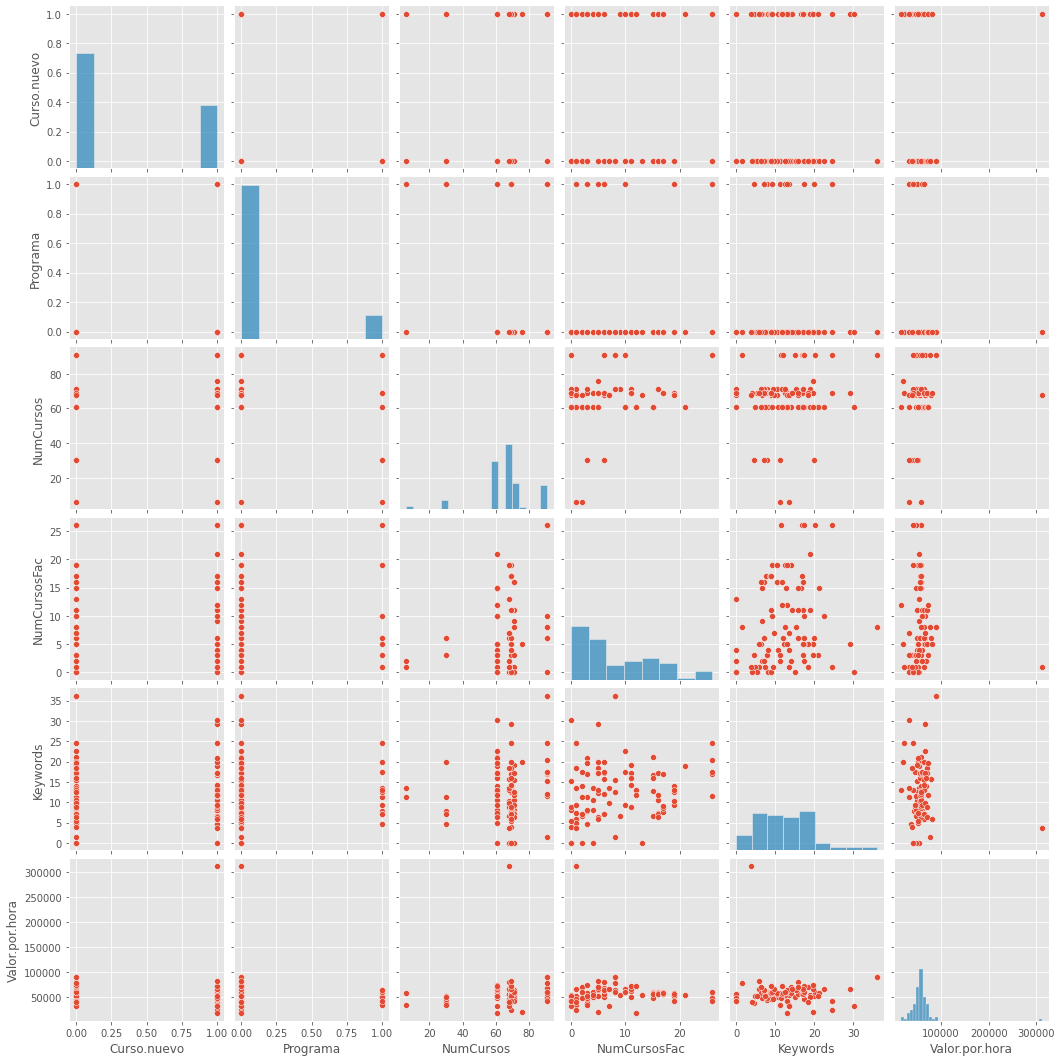

In [ ]:
# grafica para ver la correlacion de las variables numericas 
sns.pairplot(predict_df.loc[:, columnas])

In [ ]:
predict_df.to_csv('/content/predecir.csv', sep=';', index=False)

In [ ]:
predictions = pipe.predict_proba(df_to_predict)

In [ ]:
display(predict_df)

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Consectutivo curso,Keywords_list,Nombre
0,1,0,61,4,10.66,48888.890625,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038024,"arquitectura, arquitectos, bim, arquitectura i...",Metodología de diseño y procesos BIM para la a...
1,1,0,61,5,12.28,52083.328125,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038228,"Design Thinking, innovación",Metodologías de Design Thinking para la innova...
2,0,0,69,3,17.07,58043.750000,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038441,"Proyectos, proyectos inmobiliarios, arquitectu...",Herramientas para formular proyectos inmobilia...
3,1,1,30,3,7.81,43750.000000,"Arte, Ciencias y Humanidades",Presencial,ARTES Y HUMANIDADES,CUR-0037833,"taller de pintura, clases de dibujo, aprender...",Pintura
4,1,1,30,3,4.55,37000.000000,Actualización Profesional,Semipresencial / Blended,ARTES Y HUMANIDADES,CUR-0037838,"periodismo, cursos periodismo, narración perio...",Periodismo y Storytelling
...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,0,61,12,12.98,16444.439453,Actualización Profesional,Virtual,INGENIERIA,CUR-0038427,"Programación, Python, manipulación, visualizac...",Aprende a programar en Python: de los principi...
92,1,0,61,12,11.86,71875.000000,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0038359,"Impresión, ingeniería, bioimpresión 3D en salud",Impresión y bioimpresión 3D en salud
93,1,0,69,5,5.89,81481.476562,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0039407,"Hidrógeno, hoja de ruta, gerencia de proyecto,...","Hidrógeno (H2): Ciencia, tecnología y formulac..."
94,0,0,68,1,18.52,38888.890625,Actualización Profesional,Virtual,MEDICINA,CUR-0038216,"Fundamentos Anatómicos, fundamentos fisiológic...",Fundamentos Anatómicos y Fisiológicos en Acupu...


In [ ]:
predict_df['probability_1'] = predictions[:, 1]

In [ ]:
#Predicho
display(predict_df)

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Consectutivo curso,Keywords_list,Nombre,probability_1
0,1,0,61,4,10.66,48888.890625,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038024,"arquitectura, arquitectos, bim, arquitectura i...",Metodología de diseño y procesos BIM para la a...,0.410
1,1,0,61,5,12.28,52083.328125,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038228,"Design Thinking, innovación",Metodologías de Design Thinking para la innova...,0.420
2,0,0,69,3,17.07,58043.750000,Actualización Profesional,Virtual,ARQUITECTURA Y DISENO,CUR-0038441,"Proyectos, proyectos inmobiliarios, arquitectu...",Herramientas para formular proyectos inmobilia...,0.630
3,1,1,30,3,7.81,43750.000000,"Arte, Ciencias y Humanidades",Presencial,ARTES Y HUMANIDADES,CUR-0037833,"taller de pintura, clases de dibujo, aprender...",Pintura,0.240
4,1,1,30,3,4.55,37000.000000,Actualización Profesional,Semipresencial / Blended,ARTES Y HUMANIDADES,CUR-0037838,"periodismo, cursos periodismo, narración perio...",Periodismo y Storytelling,0.190
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1,0,61,12,12.98,16444.439453,Actualización Profesional,Virtual,INGENIERIA,CUR-0038427,"Programación, Python, manipulación, visualizac...",Aprende a programar en Python: de los principi...,0.490
92,1,0,61,12,11.86,71875.000000,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0038359,"Impresión, ingeniería, bioimpresión 3D en salud",Impresión y bioimpresión 3D en salud,0.250
93,1,0,69,5,5.89,81481.476562,Actualización Profesional,Semipresencial / Blended,INGENIERIA,CUR-0039407,"Hidrógeno, hoja de ruta, gerencia de proyecto,...","Hidrógeno (H2): Ciencia, tecnología y formulac...",0.290
94,0,0,68,1,18.52,38888.890625,Actualización Profesional,Virtual,MEDICINA,CUR-0038216,"Fundamentos Anatómicos, fundamentos fisiológic...",Fundamentos Anatómicos y Fisiológicos en Acupu...,0.570


In [ ]:
predict_df.to_csv('/content/Predicciones_sin.csv', sep=';', index=False)

In [ ]:
#Predicciones base de entrenamiento y validacion
base_df = base[list(X_2.columns) + ['Consecutivo.del.curso', 'Nombre.del.curso', 'Exitoso2']]
base_df = base_df.dropna()
predicciones = pipe.predict_proba(base_df[X_2.columns])
base_df['probability_1'] = predicciones[:, 1]

In [ ]:
base_df.to_csv('/content/Predicciones_Entrenamiento_sin.csv', sep=';', index=False)

In [ ]:
def make_keywords(x):
  x_list = list(x)
  x_list = [i for i in x_list if not isinstance(i, float)]
  return ', '.join(x_list)

In [ ]:
base['Keywords_org'] = base[[f'kw{i+1}' for i in range(5)]].apply(make_keywords, axis=1)
columns_to_take = features_col + ['Fecha.de.inicio', 'Fecha.de.creación', 'Keywords_org', 'Consecutivo.del.curso', 'Exitoso2', 'Nombre.del.curso'] + [f'kw{i+1}' for i in range(5)]
exitosos = base[(base['Exitoso2'] == 1) & (base['Valor.por.hora'].notna())][columns_to_take].head()
no_exitosos = base[(base['Exitoso2'] == 0) & (base['Valor.por.hora'].notna())][columns_to_take].head()
df_to_append = pd.concat([exitosos, no_exitosos])

In [ ]:
#Original
predictions = pipe.predict_proba(df_to_append[features_col])
df_to_append['probability_1'] = predictions[:, 1]
display(df_to_append[features_col + ['Consecutivo.del.curso', 'Nombre.del.curso', 'probability_1']])

,Curso.nuevo,Programa,NumCursos,NumCursosFac,Keywords,Valor.por.hora,Categoría,Modalidad,Facultad,Consecutivo.del.curso,Nombre.del.curso,probability_1
5,1,1,6,4,7.571429,136364.0,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,CUR-0018294,Programa de Liderazgo en Ingeniería - Nivel Se...,0.120000
7,1,1,23,10,1.071429,71188.0,Niños y Jóvenes,Presencial,ARTES Y HUMANIDADES,CUR-0018847,Ciclo de Iniciación musical EMI-2,0.685500
12,0,1,23,1,12.828571,87083.0,Actualización Profesional,Presencial,CIDER,CUR-0018513,Curso Fuentes de financiación y formulación de...,0.860000
14,1,1,23,1,7.476190,70125.0,Actualización Profesional,Presencial,CENTRO DE SERVICIOS INTEGRALES EN GENETICA - S...,CUR-0018672,Curso Medicina Genómica ? aplicaciones en gené...,0.740000
15,1,1,23,3,8.178571,48667.0,Actualización Profesional,Presencial,MEDICINA,CUR-0021464,Curso de Soporte Vital Avanzado ACLS (Advanced...,0.760000
0,0,1,6,1,6.238095,45000.0,Actualización Profesional,Presencial,ECONOMIA,CUR-0018831,Curso de Matemáticas para Posgrados,0.190000
1,1,1,6,4,6.977778,0.0,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,CUR-0017474,Programa de Liderazgo en Ingeniería - Nivel Ju...,0.030000
2,1,1,6,4,7.571429,0.0,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,CUR-0018293,Programa de Liderazgo en Ingeniería - Nivel Se...,0.030000
4,0,1,6,4,6.977778,37500.0,Bienestar - Desarrollo Personal,Presencial,INGENIERIA,CUR-0017475,Programa de Liderazgo en Ingeniería - Nivel Ju...,0.073333
6,1,1,23,10,1.071429,75000.0,Niños y Jóvenes,Presencial,ARTES Y HUMANIDADES,CUR-0018846,Ciclo de Iniciación musical EMI-1,0.560500


In [ ]:
# df_to_append = spark.createDataFrame(df_to_append)

In [ ]:
# df_to_append = df_to_append.withColumn('Fecha.de.inicio', F.date_format(F.to_date('`Fecha.de.inicio`', 'yyyy-MM-dd'), 'dd/MM/yyyy'))
# df_to_append = df_to_append.withColumn('Fecha.de.creación', F.date_format(F.to_date('`Fecha.de.creación`', 'yyyy-MM-dd'), 'dd/MM/yyyy'))
# df_to_append = df_to_append.withColumn('Keywords', F.col('Keywords_org'))

In [ ]:
# df_to_append.toPandas().to_csv('/dbfs/mnt/analiticastorage_educacion-continua/99Prueba/BV_Conjunto_Entrenamiento_Original.csv', sep=';', index=False)

In [ ]:
# df_to_append.select(
#     '`Consecutivo.del.curso`','`Nombre.del.curso`','`Fecha.de.inicio`',
#     '`Fecha.de.creación`','`Curso.nuevo`','Programa',
#     'NumCursos','NumCursosFac','Keywords','`Valor.por.hora`',
#     'Categoría','Facultad','Modalidad'
#   ).toPandas().to_csv('/dbfs/mnt/analiticastorage_educacion-continua/99Prueba/BV_Conjunto_Entrenamiento_Adaptado.csv', sep=';', index=False)